# Estimation of internal nodes and phylogenetic mean from shape observations

In this notebook we estimate the inner nodes and mean of a phylogenetic tree, where only the leaf node values are known. This aim is the same as in the example notebook mean_estimation.ipynb. The current notebook adds another layer of complexity in that nodes values are no longer assumed to be vectors, but _shapes_; in our case discretized outline curves describing the wing morphology of certain butterfly species. The inner nodes thus represent wing shapes of ancestral butterfly species.

As in mean_estimation.ipynb we use a simple, recursive estimator for the inner nodes; any inner node will be estimated as a weighted mean of its children. Due to the _non-linear_ nature of shapes, we cannot use the ordinary 'Euclidean' weighted mean. Luckily, the python library _jaxgeometry_ is built for handling such data, including computing weighted means of shape observations. Below, we construct a 'fuse' function which computes such weighted means of shapes using jaxgeometry. 


__Content of the notebook__

1. We load a dataset of shapes of 4 butterfly species and an associated evolutionary tree (phylogeny) for these species 

2. We estimate and plot the inner nodes, i.e. the estimated shapes of ancestral butterfly species. 

## 1. load example data

The example data is 4 observations of butterfly wings, also described in Baker et. al. 2024, https://doi.org/10.48550/arXiv.2402.01434 .
We represent each wing by 25 landmarks.  

We also load a phylogeny for these 4 species, i.e. a tree with 4 leaf nodes.

In [14]:
# Create a new Hyperiax client

import hyperiax
from jax.random import PRNGKey, split
import jax
from jax import numpy as jnp

key = PRNGKey(0)

In [15]:
import pandas as pd
import numpy as np
import requests 

from hyperiax.tree.topology import read_tree
from hyperiax.tree import HypTree
# Load all files
tree_string = requests.get("https://raw.githubusercontent.com/MichaelSev/Hyperiax_data/main/tree.txt").text
tree = read_tree(tree_string)
landmark = pd.read_csv("https://raw.githubusercontent.com/MichaelSev/Hyperiax_data/main/landmarks.csv", sep=",", header=None)

((Graphium_evemon:0.06883,Graphium_sarpedon:0.06835)QS1810:0.13941,(Atrophaneura_dixoni:0.0434,Pachliopta_aristolochiae:0.05484)QS1845:0.16755)QS1804:0;



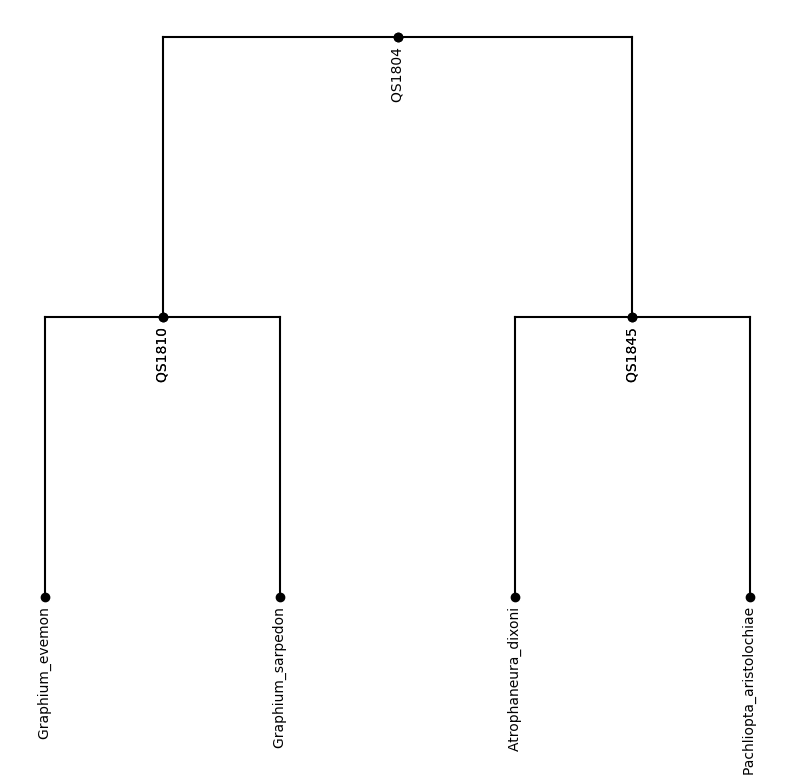

In [16]:
from hyperiax.plotting import plot_tree
plot_tree(tree,inc_names=True)
print(tree_string)

In [17]:
# The name of the landmarks are placed in the tree, alongside with the edgelength 
l_dim = (jnp.shape(landmark)[1])
tree.add_property('value', shape=(int(jnp.shape(landmark)[1]),))
# add landmarks
landmark_array = landmark.to_numpy()
reshaped_array = landmark_array.reshape(landmark_array.shape[0], landmark_array.shape[1])
tree.data['value'] = tree.data['value'].at[tree.is_leaf].set(reshaped_array)


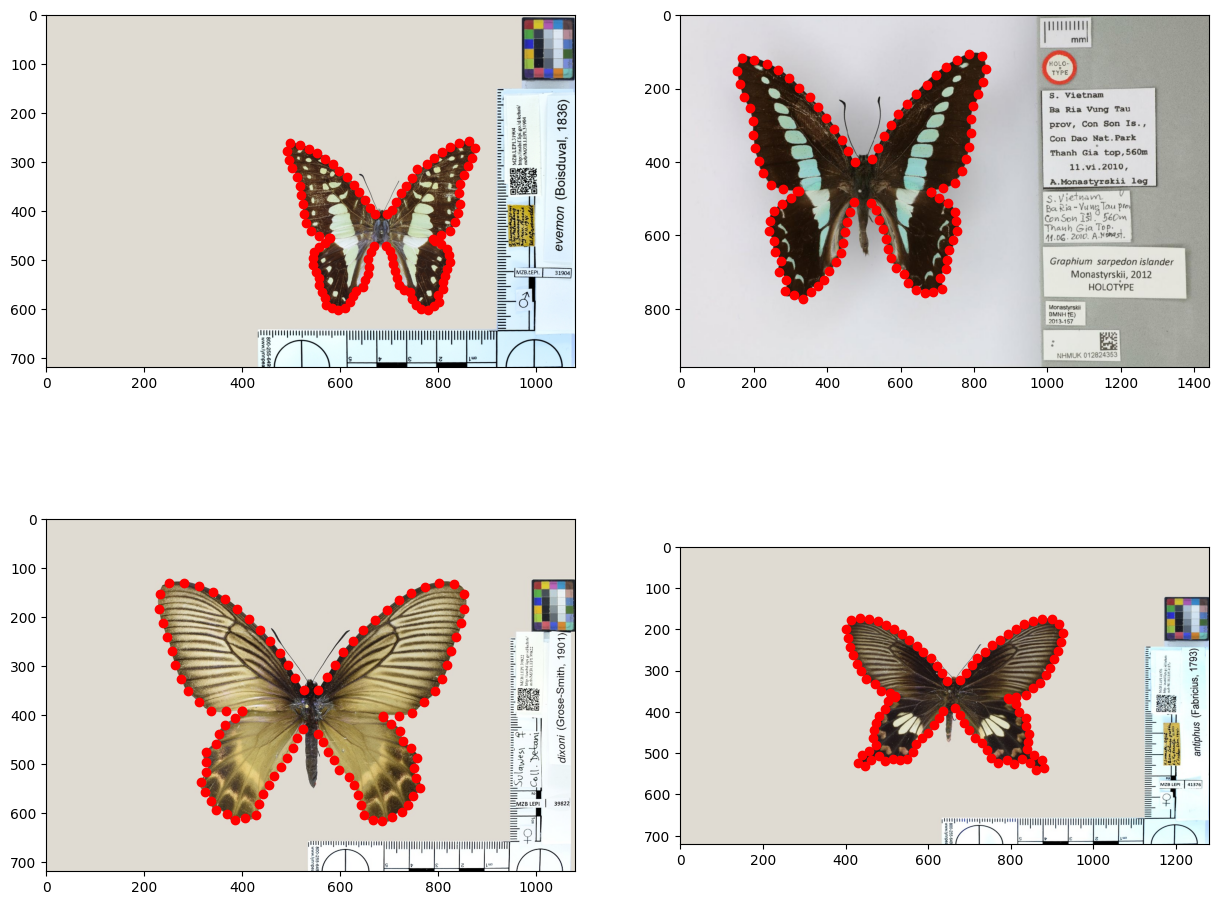

In [18]:
# Example of landmarks 
import matplotlib.pyplot as plt
from PIL import Image

main_path = "https://github.com/MichaelSev/Hyperiax_data/raw/main/image/"

list_of_names =["img0.jpg","img1.jpg","img2.jpg","img3.jpg"]
for i,data in enumerate(tree.data['value'][tree.is_leaf]):
    plt.subplot(2,2,i+1)
    im = Image.open(requests.get(main_path+list_of_names[i], stream=True).raw)
    implot = plt.imshow(im)
    plt.scatter(data[::2],data[1::2],c="r")
    #plt.title(str(leaf.name))

## Prepare tree for computing

We load in the packages and reload the tree with precumted children for faster compution, and fix the space we expect to use for each parameter.


In [19]:
from hyperiax.execution import OrderedExecutor
from hyperiax.models import UpLambdaReducer, DownLambda, UpLambda
from hyperiax.models.functional import pass_up
from hyperiax.plotting import plot_tree_text, plot_tree_2d_scatter

from matplotlib import pyplot as plt


from functools import partial

# Requires Jaxdifferentalgeometry package
from jaxgeometry.manifolds.landmarks import *   
from jaxgeometry.Riemannian import metric
from jaxgeometry.dynamics import Hamiltonian
from jaxgeometry.Riemannian import Log
from jaxgeometry.dynamics import flow_differential



In [20]:
toplogy  = read_tree(tree_string,return_topology=True)
pre_tree = HypTree(toplogy, precompute_child_gathers=True)
pre_tree.data = tree.data.copy()

In [21]:
# Saved parameters within the tree 
pre_tree.add_property('sigma', shape=(1,))

# Fixed sigma for simplification
pre_tree.data['sigma'] =  pre_tree.data['sigma'].at[:].set(0.5)

## 2. compute inner nodes (i.e. ancestral shapes)

We compute the inner nodes of the tree, i.e. the wing shapes of ancestral species. For this we need to define a 'fuse' function which computes a non-linear version of a weighted mean: each inner node is a non-linear weighted mean of its children nodes. The particular non-linear weighted mean we compute is based on the LDDMM framework, as implemented in the jaxgeometry library.

Note this is a quicker version of the code, since we exclude the contrast and lift function for the tangent space

In [22]:
import jax.numpy as jnp
from jax import vmap, lax

def fuse_lddmm(child_value, child_sigma, child_edge_length, **kwargs):
    def lddmm(child_coords1, child_coords2, kernel_sigma, parent_index):
        # Estimate the average distance between each landmark,
        # predefined kernel size 
        M = landmarks(jnp.shape(child_coords1)[0] // 2, k_sigma=kernel_sigma * jnp.eye(2))
        # Riemannian structure

        metric.initialize(M)
        q = M.coords(jnp.array(child_coords1))
        v = (jnp.array(child_coords2), [0])
        Hamiltonian.initialize(M)
        # Logarithm map
        Log.initialize(M, f=M.Exp_Hamiltonian)

        # Estimate momentum 
        p = M.Log(q, v)[0]

        # Hamiltonian 
        (_, qps, charts_qp) = M.Hamiltonian_dynamics(q, p, dts(n_steps=100))

        # Return landmarks, contrast and phi
        return qps[parent_index, 0, :]

    # Map function, to determine the shortest branch from child to parent 
    def mapfunction(child_coords_pair, child_edge_length_pair, kernel_sigma_pair):
        edge_length_sum = child_edge_length_pair.sum()

        def true_fun(_):
            parent_index = jnp.floor(child_edge_length_pair[0] / edge_length_sum * 100 - 1).astype(int)[0]
            return lddmm(child_coords_pair[0, :], child_coords_pair[1, :], kernel_sigma_pair[:, 0], parent_index)

        def false_fun(_):
            parent_index = jnp.floor(child_edge_length_pair[1] / edge_length_sum * 100 - 1).astype(int)[0]
            return lddmm(child_coords_pair[1, :], child_coords_pair[0, :], kernel_sigma_pair[:, 0], parent_index)

        # Run Upwards LDDMM; from either left or right 
     
        return lax.cond((child_edge_length_pair[0] < child_edge_length_pair[1])[0], true_fun, false_fun, operand=None)

    # vmap to iterate over set of children
    qps = vmap(mapfunction, in_axes=(0, 0, 0))(child_value, child_edge_length, child_sigma)
    
    return {'value': qps}

In [23]:


upmodel = UpLambda(up_fn=fuse_lddmm)
upmodelexe = OrderedExecutor(upmodel)
res = upmodelexe.up(pre_tree)



## 2.1 Plots
We can now plot one of the estimated inner nodes, computed as the weighted mean of two neighbouring leaf-node shapes. The two leaf shapes are represented by the red and green points, the estimated inner node is represented by the blue points.

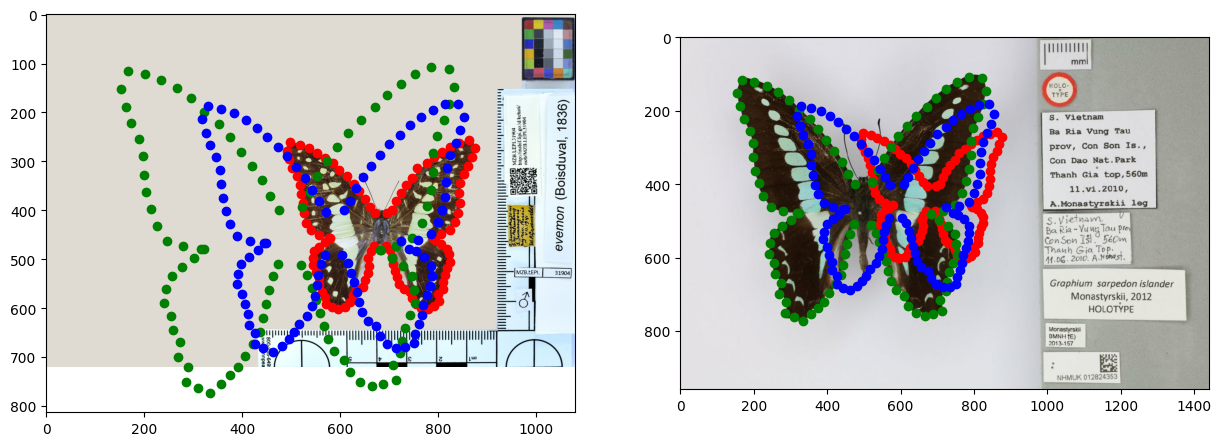

In [24]:
import matplotlib.pyplot as plt
from PIL import Image
import requests

# Illustrate the results
plt.subplot(1, 2, 1)
# Load image 
im = Image.open(requests.get(main_path + "img0.jpg", stream=True).raw)
implot = plt.imshow(im)

# Plot points
plt.scatter(pre_tree.data['value'][3][::2], pre_tree.data['value'][3][1::2], color='red')    # child1 of root
plt.scatter(pre_tree.data['value'][4][::2], pre_tree.data['value'][4][1::2], color='green')  # child2 of root

plt.scatter(pre_tree.data['value'][1][::2], pre_tree.data['value'][1][1::2], color='blue')   # root


plt.subplot(1, 2, 2)
# Load image
im = Image.open(requests.get(main_path + "img1.jpg", stream=True).raw)
implot = plt.imshow(im)

# Plot points
plt.scatter(pre_tree.data['value'][3][::2], pre_tree.data['value'][3][1::2], color='red')    # child1 of root
plt.scatter(pre_tree.data['value'][4][::2], pre_tree.data['value'][4][1::2], color='green')  # child2 of root

plt.scatter(pre_tree.data['value'][1][::2], pre_tree.data['value'][1][1::2], color='blue')   # root


plt.show()

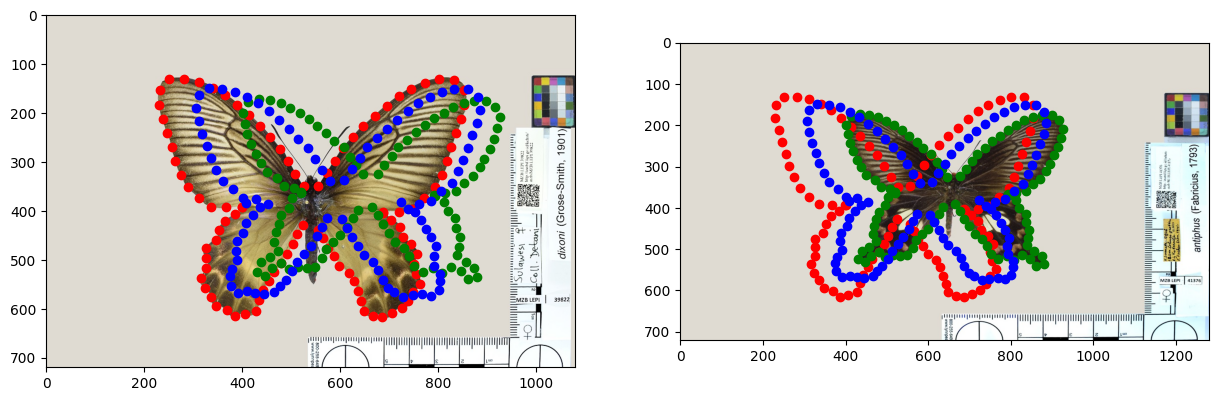

In [25]:
import matplotlib.pyplot as plt
from PIL import Image
import requests

# Illustrate the results
plt.subplot(1, 2, 1)
# Load image 
im = Image.open(requests.get(main_path + "img2.jpg", stream=True).raw)
implot = plt.imshow(im)

# Plot points
plt.scatter(pre_tree.data['value'][5][::2], pre_tree.data['value'][5][1::2], color='red')    # child1 of root
plt.scatter(pre_tree.data['value'][6][::2], pre_tree.data['value'][6][1::2], color='green')  # child2 of root

plt.scatter(pre_tree.data['value'][2][::2], pre_tree.data['value'][2][1::2], color='blue')   # root


plt.subplot(1, 2, 2)
# Load image
im = Image.open(requests.get(main_path + "img3.jpg", stream=True).raw)
implot = plt.imshow(im)

# Plot points
plt.scatter(pre_tree.data['value'][5][::2], pre_tree.data['value'][5][1::2], color='red')    # child1 of root
plt.scatter(pre_tree.data['value'][6][::2], pre_tree.data['value'][6][1::2], color='green')  # child2 of root


plt.scatter(pre_tree.data['value'][2][::2], pre_tree.data['value'][2][1::2], color='blue')   # root


plt.show()

The points on the left and right figures are identical, the only difference is the superimposed image.

Next, we plot all leaf nodes (points in light colors) along with the estimated root node shape (blue points), i.e. the common ancestor of all 4 species.

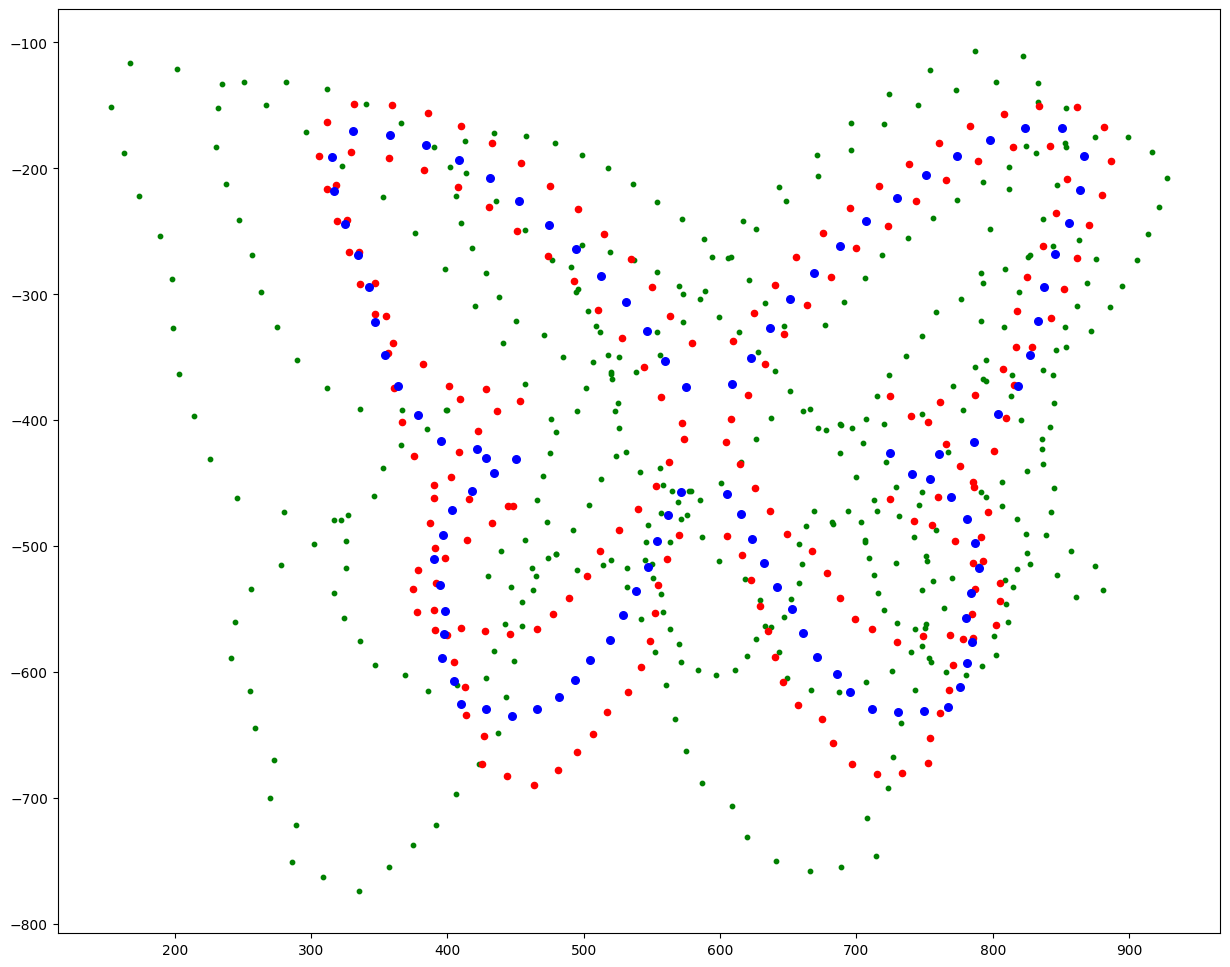

In [26]:


for i,data in enumerate(pre_tree.data['value'][pre_tree.is_leaf]):   
    plt.scatter(data[::2],-data[1::2],color="green",s=10)

for i,data in enumerate(pre_tree.data['value'][pre_tree.is_inner]):   
    plt.scatter(data[::2],-data[1::2],color="red",s=20)

plt.scatter(pre_tree.data['value'][0][::2], -pre_tree.data['value'][0][1::2], color='blue',s=30)    # root
   
   